In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

## User input

In [2]:
sample_prefix = 'E:\\Ashlee\\PacBio\\181207\\30s_43N43\\m181207_211324_42131_c000468682559900001500000112312060_s1_p0'

## Load data

In [3]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

## View data structure
def printname(name):
    print(name)

print('In mcd file: ')
mcd_file.visit(printname)
print()

print('In upd file: ')
upd_file.visit(printname)

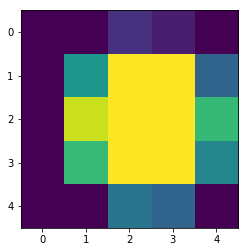

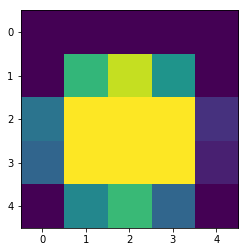

In [4]:
psf = mcd_file['MovieCal']['Camera[0]']['Psf']
for i in range(1, 3):
    fig, ax = plt.subplots()
    im = ax.imshow(psf[0, i, :, :])

## Decode trace intensities

In [5]:
traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    traces[i] = decode_array[raw_traces[i]]

In [6]:
traces2 = np.zeros(raw_traces.shape, dtype=np.float16)
for i in range(n_traces):
    traces2[i] = decode_array[raw_traces[i]]

## Plot intensity distributions

In [7]:
avg_intens = np.mean(traces, axis=2)

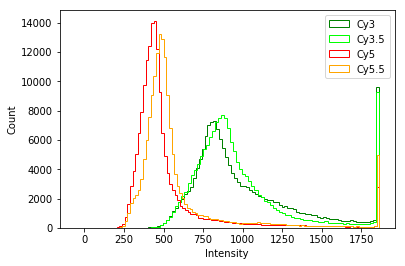

In [8]:
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend(lasers)

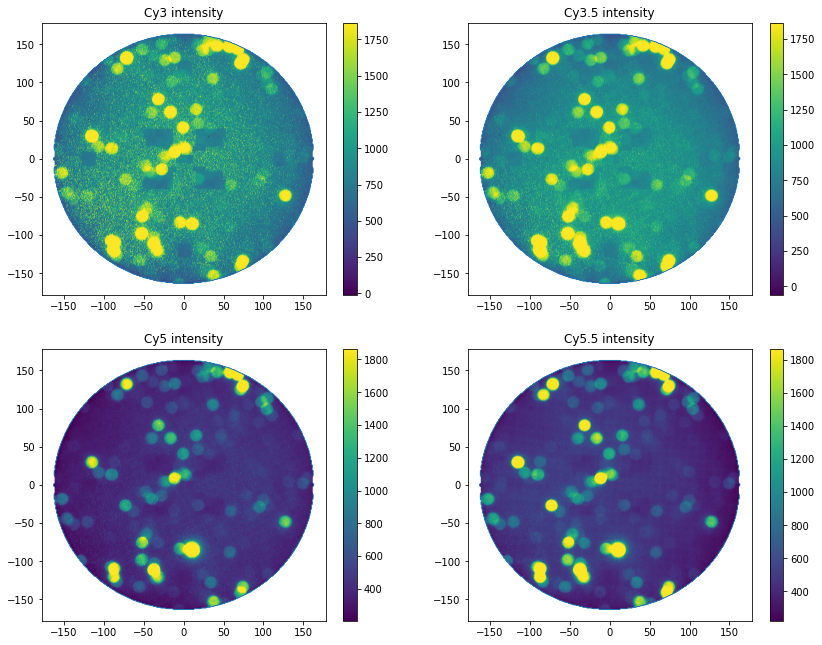

In [9]:
# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i]/300)
#     plt.title(lasers[i] + ' intensity')
#     plt.show()

plt.figure(figsize=(14, 11))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()

plt.savefig(sample_prefix + '_grid.png')
plt.show()

## Plot variance distributions

In [10]:
var = np.log10(np.var(traces, axis=2) + 1e-6)

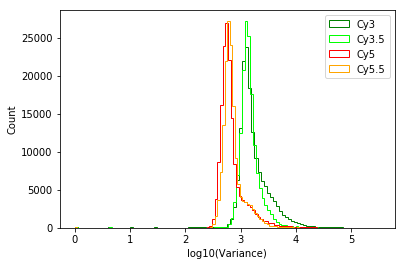

In [11]:
for i in range(4):
    var_i = var.T[i]
    min_i = 0
    max_i = max(var_i)
    plt.hist(var_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('log10(Variance)')
plt.ylabel('Count')
plt.legend(lasers)

In [12]:
# Plot variance over the grid

# for i in range(4):
#     plt.figure()
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
#     plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, var.T[i])
#     plt.title('log10(Variance) of ' + lasers[i])
#     plt.show()

## View a trace

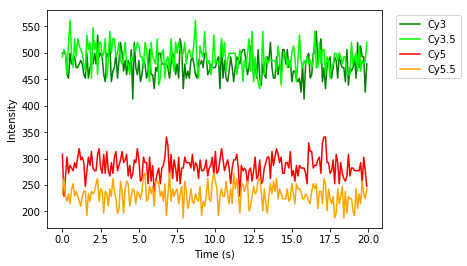

In [13]:
# i = 112542 # is a good example
i = 4
# i = np.random.randint(0, n_traces)
trace = traces[i]
for j in range(4):
    plt.plot(time_axis, trace[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

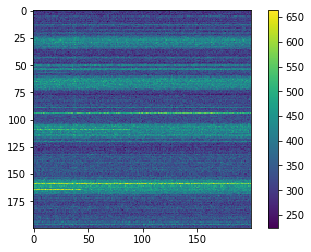

In [14]:
plt.imshow(traces[:200, 2, :])
plt.colorbar()

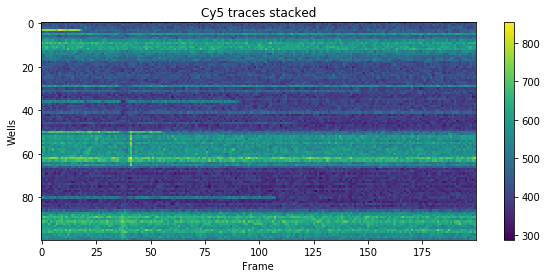

In [15]:
plt.figure(figsize=(10, 4))
plt.imshow(traces[(112542-50):(112542+50), 2, :])
plt.colorbar()
plt.title("Cy5 traces stacked")
plt.xlabel("Frame")
plt.ylabel('Wells')
plt.savefig(sample_prefix + '_cy5_stacked_example.png', dpi=300)

## Plot average intensity over time for each color

In [16]:
avg_trace = np.zeros((4, 200))
for i in range(4):
    avg_trace[i] = np.mean(traces[:][:][i], axis=0)

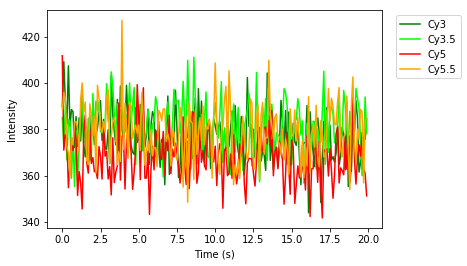

In [17]:
for i in range(4):
    plt.plot(time_axis, avg_trace[i], color=colors[i])

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

## Sort by correlation

In [26]:
# zero-center the traces
centered_traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    for j in range(4):
        centered_traces[i, j] = traces[i, j] - avg_intens[i, j]

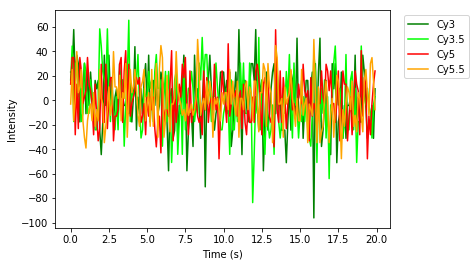

In [39]:
i = np.random.randint(0, n_traces)
i = 0
ct = centered_traces[i]
for j in range(4):
    plt.plot(time_axis, ct[j], color=colors[j])
    j += 1 

plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [41]:
# Compute cross-correlation
corr_list = np.zeros(n_traces)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][2]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

sorted_ct = traces[sorting_index]

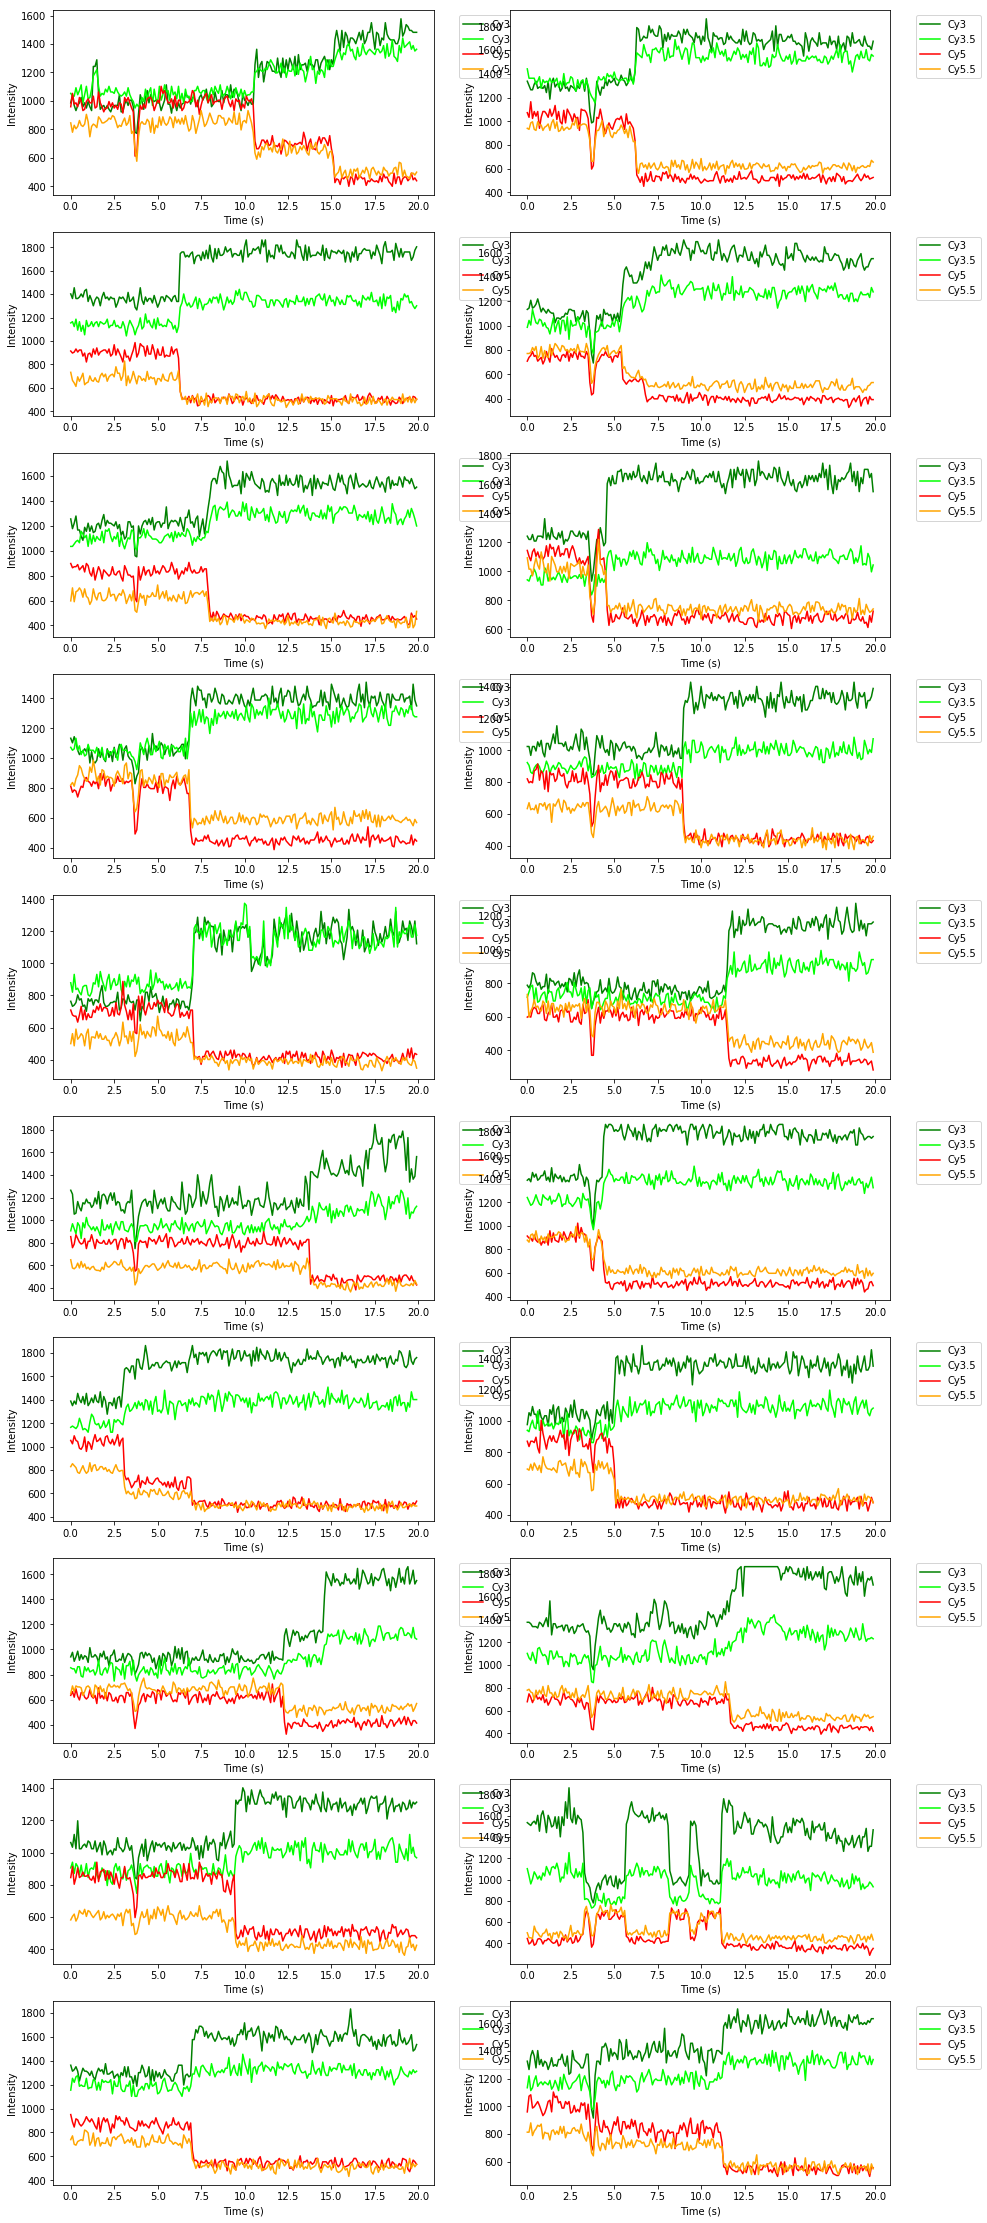

In [69]:
plt.figure(figsize=(15, 40))
for i in range(20):
    plt.subplot(10, 2, i+1)
    st = sorted_ct[i]
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1
# plt.savefig("Top 20 anticorrelated traces.png")